In [1]:
import numpy as np 
import math
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

L, d_k, d_v = 4, 8, 8
# L is the number of words
# d_k, and d_v are the respective sizes of emb for query, key's and values.
q = np.random.randn(L, d_k)
k = np.random.randn(L, d_k)
v = np.random.randn(L, d_v)

## Query: What I am looking for
## Key: What I currently have
## Value: What I actually offer

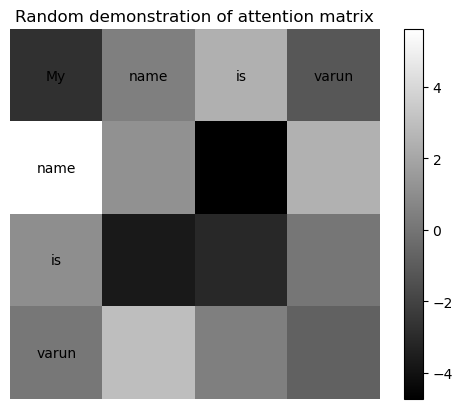

In [2]:
att = np.matmul(q, k.T)
text = "My name is varun"
l = text.split()
l = l + l[1:]
idx = 0

fig, ax = plt.subplots()
plt.title("Random demonstration of attention matrix")
plt.imshow(att, cmap="gray")
plt.colorbar()
for i in range(att.shape[0]):
    for j in range(att.shape[1]):
        if i == 0 or j == 0:
            ax.text(j, i, l[idx], ha='center', va='center')
            idx += 1
        ax.axis("off")

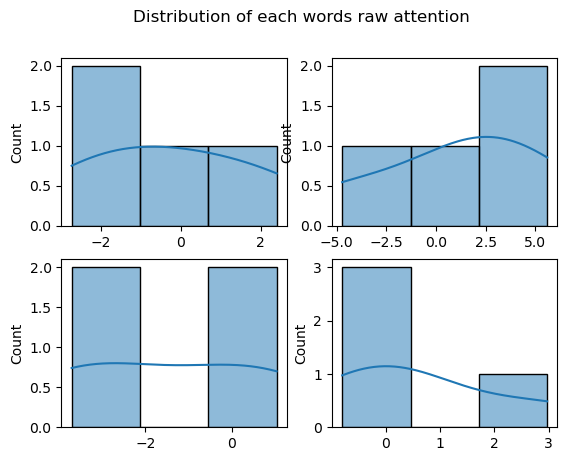

In [3]:
fig, ax = plt.subplots(nrows=2, ncols=2)
for i in range(2):
    for j in range(2):
        sns.histplot(att[i*2 + j], kde=True, ax=ax[i, j])

fig.suptitle("Distribution of each words raw attention");

## Comparing variances

## The variances of q, k, v are close to 0/1, but the variance of the q.k.T is not

## Q: why do we need to make variance of output close to 0/1?
## Ans: It has several reasons:
- Stability during training: If we don't do this, the values might explode or opposite.
- It also makes sure that the attention scores are not dominated by the magnitude of input vectors

## Q: why divide by sqrt(d_k)? why not something else?
#### Ans: According to my current search, it is just a heuristic or convention that has been found to work well in practice

In [4]:
q.var(), k.var(), v.var(), att.var(), (att/np.sqrt(d_k)).var()

(0.8669372677550163,
 0.7119028180363141,
 0.918527941351633,
 6.837565240983166,
 0.8546956551228956)

## Masking
Generally used in the Decoder part of the Transformer. It is used so that current words doesn't get any context from the future words

We made the mask of -inf cause we are going to use Softmax

In [5]:
mask = np.tril(np.ones((L, L)))
print(f"normal mask: {mask}")
mask[mask == 0] = -np.infty
print(f"changed mask {mask}")

normal mask: [[1. 0. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 1. 0.]
 [1. 1. 1. 1.]]
changed mask [[  1. -inf -inf -inf]
 [  1.   1. -inf -inf]
 [  1.   1.   1. -inf]
 [  1.   1.   1.   1.]]


## Final att after masking 

In [6]:
def softmax(x: np.array) -> np.array:
    return (np.exp(x).T / np.sum(np.exp(x), axis=-1)).T
dec_att = softmax(att + mask)
enc_att = softmax(att)
print(f"Encoder attention matrix: {enc_att}")
print(f"Decoder attention matrix: {dec_att}")

Encoder attention matrix: [[5.10604035e-03 1.17001393e-01 8.54066954e-01 2.38256123e-02]
 [9.48599292e-01 1.11858902e-02 3.11174749e-05 4.01837008e-02]
 [7.16363959e-01 6.24419016e-03 1.21491406e-02 2.65242711e-01]
 [4.86667519e-02 8.63215852e-01 6.82292118e-02 1.98881843e-02]]
Decoder attention matrix: [[1.         0.         0.         0.        ]
 [0.98834542 0.01165458 0.         0.        ]
 [0.97496679 0.0084983  0.0165349  0.        ]
 [0.04866675 0.86321585 0.06822921 0.01988818]]


## New embeddings for each words (which are context aware)

In [7]:
np.matmul(enc_att, v), np.matmul(dec_att, v)

(array([[-0.20027927,  0.50721746,  0.95765188, -0.31827109, -0.69520336,
         -0.47461915,  0.78505392,  0.02121126],
        [ 0.74906611,  1.32466636, -0.09366601,  1.00005192,  0.31578513,
         -0.6284871 ,  0.32811817,  1.37794845],
        [ 0.43865665,  1.12181046, -0.02423939,  0.9746564 ,  0.06356958,
         -0.55701351,  0.16658128,  0.70519058],
        [-0.01690662,  1.45120247, -2.16214376,  0.74222138,  0.02361462,
         -0.33025486,  0.15145615, -1.64752598]]),
 array([[ 0.81252582,  1.35624003, -0.07201012,  1.0035329 ,  0.36163603,
         -0.64511975,  0.36139561,  1.53803657],
        [ 0.80263864,  1.35866888, -0.10170289,  1.00141607,  0.35843581,
         -0.64108596,  0.35825313,  1.49694713],
        [ 0.78824898,  1.34149063, -0.06803403,  0.97682648,  0.3399545 ,
         -0.6398079 ,  0.36826461,  1.48807948],
        [-0.01690662,  1.45120247, -2.16214376,  0.74222138,  0.02361462,
         -0.33025486,  0.15145615, -1.64752598]]))

## Compressing everything into a function

In [23]:
def softmax(x: np.array) -> np.array:
    return (np.exp(x).T / np.sum(np.exp(x), axis=-1)).T


def scaled_dot_product(q, k, v, mask=None):
    dim = q.shape[-1]
    att = np.matmul(q, k.T)

    if mask is not None:
        att += mask
    att = softmax(att/np.sqrt(dim))
    print(f"att: {att}")
    print(f"v: {v}")
    new_emb = np.matmul(att, v)
    print(f"new v {new_emb}")
    return new_emb, att

a, b = scaled_dot_product(q, k, v, mask)


att: [[1.         0.         0.         0.        ]
 [0.82776862 0.17223138 0.         0.        ]
 [0.7024564  0.13134709 0.16619652 0.        ]
 [0.17794451 0.49185018 0.20052305 0.12968226]]
v: [[ 0.81252582  1.35624003 -0.07201012  1.0035329   0.36163603 -0.64511975
   0.36139561  1.53803657]
 [-0.03582604  1.56464366 -2.6197451   0.8219025   0.08704707 -0.29900735
   0.09176078 -1.98756891]
 [-0.21967189  0.35711257  1.47789404 -0.51827022 -0.8084936  -0.50175704
   0.91540212  0.32875111]
 [-0.5297602   0.51326743  0.09707755  0.96864499 -0.70205309 -0.32766215
  -0.39210815 -1.46351495]]
new v [[ 0.81252582  1.35624003 -0.07201012  1.0035329   0.36163603 -0.64511975
   0.36139561  1.53803657]
 [ 0.66641301  1.39213367 -0.51081002  0.97225045  0.31434319 -0.58550834
   0.31495603  0.93081668]
 [ 0.52954961  1.21756173 -0.14905901  0.7267579   0.1310981  -0.57583252
   0.41805381  0.87397953]
 [ 0.01421368  1.14907671 -0.99239485  0.60451701 -0.14600018 -0.40496816
   0.24215067 -

In [20]:
a

array([[ 0.81252582,  1.35624003, -0.07201012,  1.0035329 ,  0.36163603,
        -0.64511975,  0.36139561,  1.53803657],
       [ 0.66641301,  1.39213367, -0.51081002,  0.97225045,  0.31434319,
        -0.58550834,  0.31495603,  0.93081668],
       [ 0.52954961,  1.21756173, -0.14905901,  0.7267579 ,  0.1310981 ,
        -0.57583252,  0.41805381,  0.87397953],
       [ 0.01421368,  1.14907671, -0.99239485,  0.60451701, -0.14600018,
        -0.40496816,  0.24215067, -0.82777073]])

In [19]:
b

array([[1.        , 0.        , 0.        , 0.        ],
       [0.82776862, 0.17223138, 0.        , 0.        ],
       [0.7024564 , 0.13134709, 0.16619652, 0.        ],
       [0.17794451, 0.49185018, 0.20052305, 0.12968226]])